In [179]:
import os
import torch
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import random

In [180]:
# riproducibilità
random.seed(42)
torch.manual_seed(42)

In [194]:
# CONFIGURAZIONE
base_dir = os.getcwd()
image_size = 224
batch_size = 32 #32, 16
n_components = 146
# 3, 8, 17, 40, 146
# dimensioni su cui vogliamo fare PCA, trovate con explained variance 
# e selezionado le soglie = [0.95, 0.85, 0.75, 0.65, 0.50]
epochs = 100
output_folder = os.path.join(base_dir, "pca_outputs")
save_path = os.path.join(output_folder, f'pca_data_{n_components}_augmented.pth')
pretty_labels = ['Adenocarcinoma', 'Large Cell', 'Normal', 'Squamous Cell']
log_txt_path = os.path.join(output_folder, "classification_reports.txt")

In [182]:
# RICARICA E TRAIN
data_dict = torch.load(save_path, weights_only=False)


X_train = torch.tensor(data_dict['train_data'], dtype=torch.float32)
y_train = torch.tensor(data_dict['train_labels'], dtype=torch.long)
X_val = torch.tensor(data_dict['val_data'], dtype=torch.float32)
y_val = torch.tensor(data_dict['val_labels'], dtype=torch.long)
X_test = torch.tensor(data_dict['test_data'], dtype=torch.float32)
y_test = torch.tensor(data_dict['test_labels'], dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

C:\Users\noemi\AppData\Local\Temp\ipykernel_17724\949298212.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(data_dict['train_labels'], dtype=torch.long)


In [183]:
# class FeedforwardNet(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.bn1 = nn.BatchNorm1d(hidden_dim)
#         self.dropout = nn.Dropout(dropout)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         x = self.dropout(torch.relu(self.bn1(self.fc1(x))))
#         return self.fc2(x)

class FeedforwardNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)


# class FeedforwardNet(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super().__init__()
#         self.fc = nn.Linear(input_dim, output_dim)

#     def forward(self, x):
#         return self.fc(x)


In [184]:
model = FeedforwardNet(n_components, 64, len(data_dict['class_names'])) #128, 64 (hidden layer)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

# === CLASS WEIGHTS ===
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32)
# === LOSS, OPTIMIZER, SCHEDULER ===
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [185]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=10, patience=10):
    best_val_loss = float('inf')
    trigger_times = 0
    best_model_state = model.state_dict()  # safe default

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (output.argmax(1) == y_batch).sum().item()
            total += y_batch.size(0)
        train_acc = 100 * correct / total

        # VALIDAZIONE
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
                val_correct += (output.argmax(1) == y_batch).sum().item()
                val_total += y_batch.size(0)
        val_acc = 100 * val_correct / val_total

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # EARLY STOPPING
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            best_model_state = model.state_dict()
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("🛑 Early stopping triggered.")
                break
        
                # EARLY STOPPING
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            best_model_state = model.state_dict()
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("🛑 Early stopping triggered.")
                break

        # Scheduler update
        if scheduler:
            scheduler.step(val_loss)

    # Restore best model
    model.load_state_dict(best_model_state)



In [186]:
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=epochs, patience=10)


Epoch 1/100 | Train Loss: 242.3150 | Train Acc: 60.94% | Val Loss: 2.3633 | Val Acc: 68.06%
Epoch 2/100 | Train Loss: 126.7973 | Train Acc: 79.37% | Val Loss: 2.2472 | Val Acc: 73.61%
Epoch 3/100 | Train Loss: 96.0843 | Train Acc: 84.79% | Val Loss: 2.2109 | Val Acc: 68.06%
Epoch 4/100 | Train Loss: 83.8864 | Train Acc: 86.81% | Val Loss: 2.1217 | Val Acc: 76.39%
Epoch 5/100 | Train Loss: 69.3655 | Train Acc: 89.14% | Val Loss: 2.2421 | Val Acc: 73.61%
Epoch 6/100 | Train Loss: 61.4546 | Train Acc: 90.64% | Val Loss: 2.0972 | Val Acc: 73.61%
Epoch 7/100 | Train Loss: 56.4625 | Train Acc: 91.44% | Val Loss: 2.3066 | Val Acc: 72.22%
Epoch 8/100 | Train Loss: 51.5542 | Train Acc: 91.96% | Val Loss: 2.4219 | Val Acc: 75.00%
Epoch 9/100 | Train Loss: 46.9042 | Train Acc: 92.67% | Val Loss: 2.6674 | Val Acc: 73.61%
Epoch 10/100 | Train Loss: 43.8489 | Train Acc: 93.41% | Val Loss: 2.6676 | Val Acc: 77.78%
Epoch 11/100 | Train Loss: 39.2820 | Train Acc: 94.08% | Val Loss: 2.5274 | Val Acc: 76

In [187]:
def evaluate_test(model, test_loader, criterion):
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            test_loss += loss.item()
            test_correct += (output.argmax(1) == y_batch).sum().item()
            test_total += y_batch.size(0)
    test_acc = 100 * test_correct / test_total
    print(f"\n📊 Final Test Accuracy: {test_acc:.2f}% | Test Loss: {test_loss:.4f}")

In [188]:
evaluate_test(model, test_loader, criterion)


📊 Final Test Accuracy: 50.48% | Test Loss: 18.5758


In [189]:
y_true, y_pred = [], []
test_loss, test_correct, test_total = 0, 0, 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        loss = criterion(output, y_batch)
        test_loss += loss.item()
        preds = output.argmax(1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(preds.tolist())
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)

test_acc = 100 * test_correct / test_total
print(f"\n\U0001F9EA Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

report_txt = classification_report(y_true, y_pred, target_names=pretty_labels)
print(f"Classification Report {n_components} PCA:\n\n{report_txt}")


🧪 Test Loss: 18.5758 | Test Accuracy: 50.48%
Classification Report 146 PCA:

                precision    recall  f1-score   support

Adenocarcinoma       0.46      0.05      0.09       120
    Large Cell       0.41      0.69      0.51        51
        Normal       0.76      0.96      0.85        54
 Squamous Cell       0.45      0.73      0.55        90

      accuracy                           0.50       315
     macro avg       0.52      0.61      0.50       315
  weighted avg       0.50      0.50      0.42       315



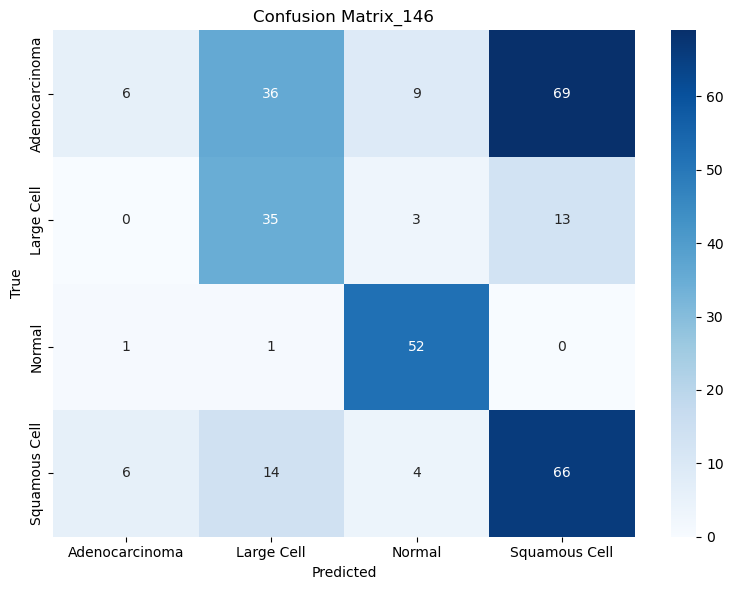

In [190]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
title = f'Confusion Matrix_{n_components}'
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=pretty_labels, yticklabels=pretty_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(title)
plot_path = os.path.join(output_folder, f'{title}.png')
plt.savefig(plot_path)
plt.tight_layout()
plt.show()

In [191]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy

results = []

# Grid di valori
n_components_list = [146]
hidden_dims = [64, 128]
dropouts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Standardizzazione
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

for n_comp in n_components_list:
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Converti in tensori
    X_train_t = torch.tensor(X_train_pca, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_val_t = torch.tensor(X_val_pca, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.long)
    X_test_t = torch.tensor(X_test_pca, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64)
    test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64)

    for hidden_dim in hidden_dims:
        for dropout in dropouts:
            # Modello
            model = FeedforwardNet(n_comp, hidden_dim, len(pretty_labels), dropout=dropout)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
            train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=scheduler, epochs=50, patience=7)


            # Eval
            model.eval()
            y_true, y_pred = [], []
            with torch.no_grad():
                for Xb, yb in test_loader:
                    out = model(Xb)
                    pred = out.argmax(1)
                    y_true.extend(yb.tolist())
                    y_pred.extend(pred.tolist())

            acc = accuracy_score(y_true, y_pred)
            print(f"🎯 n_components={n_comp}, hidden_dim={hidden_dim}, dropout={dropout} => Test Acc: {acc:.4f}")
            results.append({
                'n_components': n_comp,
                'hidden_dim': hidden_dim,
                'dropout': dropout,
                'test_acc': acc
            })

C:\Users\noemi\AppData\Local\Temp\ipykernel_17724\1757548505.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_t = torch.tensor(y_train, dtype=torch.long)
C:\Users\noemi\AppData\Local\Temp\ipykernel_17724\1757548505.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_t = torch.tensor(y_val, dtype=torch.long)
C:\Users\noemi\AppData\Local\Temp\ipykernel_17724\1757548505.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_t = torch.tensor(y_test, dtype=torch.long)


Epoch 1/50 | Train Loss: 128.6682 | Train Acc: 59.79% | Val Loss: 1.8861 | Val Acc: 66.67%
Epoch 2/50 | Train Loss: 63.0438 | Train Acc: 83.55% | Val Loss: 1.4068 | Val Acc: 69.44%
Epoch 3/50 | Train Loss: 42.4565 | Train Acc: 88.54% | Val Loss: 1.3523 | Val Acc: 70.83%
Epoch 4/50 | Train Loss: 31.3610 | Train Acc: 92.40% | Val Loss: 1.2739 | Val Acc: 70.83%
Epoch 5/50 | Train Loss: 23.7206 | Train Acc: 94.86% | Val Loss: 1.2042 | Val Acc: 73.61%
Epoch 6/50 | Train Loss: 18.8458 | Train Acc: 96.45% | Val Loss: 1.1130 | Val Acc: 73.61%
Epoch 7/50 | Train Loss: 14.9972 | Train Acc: 97.47% | Val Loss: 1.0785 | Val Acc: 75.00%
Epoch 8/50 | Train Loss: 12.4511 | Train Acc: 97.95% | Val Loss: 1.0809 | Val Acc: 76.39%
Epoch 9/50 | Train Loss: 10.9299 | Train Acc: 98.23% | Val Loss: 1.0569 | Val Acc: 72.22%
Epoch 10/50 | Train Loss: 9.5281 | Train Acc: 98.37% | Val Loss: 1.0157 | Val Acc: 80.56%
Epoch 11/50 | Train Loss: 8.2521 | Train Acc: 98.68% | Val Loss: 0.9656 | Val Acc: 79.17%
Epoch 12/

In [192]:
results.sort(key=lambda x: x['test_acc'], reverse=True)
for r in results:
    print(r)

{'n_components': 146, 'hidden_dim': 128, 'dropout': 0.5, 'test_acc': 0.580952380952381}
{'n_components': 146, 'hidden_dim': 64, 'dropout': 0.9, 'test_acc': 0.5682539682539682}
{'n_components': 146, 'hidden_dim': 64, 'dropout': 0.7, 'test_acc': 0.5650793650793651}
{'n_components': 146, 'hidden_dim': 128, 'dropout': 0.3, 'test_acc': 0.5650793650793651}
{'n_components': 146, 'hidden_dim': 64, 'dropout': 0.5, 'test_acc': 0.5619047619047619}
{'n_components': 146, 'hidden_dim': 128, 'dropout': 0.8, 'test_acc': 0.5619047619047619}
{'n_components': 146, 'hidden_dim': 64, 'dropout': 0.1, 'test_acc': 0.5587301587301587}
{'n_components': 146, 'hidden_dim': 64, 'dropout': 0.8, 'test_acc': 0.5587301587301587}
{'n_components': 146, 'hidden_dim': 64, 'dropout': 0.4, 'test_acc': 0.5555555555555556}
{'n_components': 146, 'hidden_dim': 128, 'dropout': 0.2, 'test_acc': 0.5555555555555556}
{'n_components': 146, 'hidden_dim': 128, 'dropout': 0.9, 'test_acc': 0.5555555555555556}
{'n_components': 146, 'hidde

C:\Users\noemi\AppData\Local\Temp\ipykernel_17724\1193934340.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(data_dict['train_labels'], dtype=torch.long)


Epoch 1/100 | Train Loss: 87.4910 | Train Acc: 88.51% | Val Loss: 0.3554 | Val Acc: 97.22%
Epoch 2/100 | Train Loss: 13.3952 | Train Acc: 99.45% | Val Loss: 0.3361 | Val Acc: 95.83%
Epoch 3/100 | Train Loss: 5.5969 | Train Acc: 99.82% | Val Loss: 0.4027 | Val Acc: 95.83%
Epoch 4/100 | Train Loss: 3.2801 | Train Acc: 99.86% | Val Loss: 0.4153 | Val Acc: 97.22%
Epoch 5/100 | Train Loss: 1.9918 | Train Acc: 99.96% | Val Loss: 0.4494 | Val Acc: 97.22%
Epoch 6/100 | Train Loss: 1.6663 | Train Acc: 99.90% | Val Loss: 0.4868 | Val Acc: 95.83%
Epoch 7/100 | Train Loss: 1.1202 | Train Acc: 99.97% | Val Loss: 0.5037 | Val Acc: 95.83%
Epoch 8/100 | Train Loss: 1.1012 | Train Acc: 99.95% | Val Loss: 0.5196 | Val Acc: 95.83%
Epoch 9/100 | Train Loss: 0.7134 | Train Acc: 100.00% | Val Loss: 0.5258 | Val Acc: 97.22%
Epoch 10/100 | Train Loss: 0.8147 | Train Acc: 99.99% | Val Loss: 0.5139 | Val Acc: 97.22%
Epoch 11/100 | Train Loss: 0.8230 | Train Acc: 99.96% | Val Loss: 0.5324 | Val Acc: 95.83%
Epoch

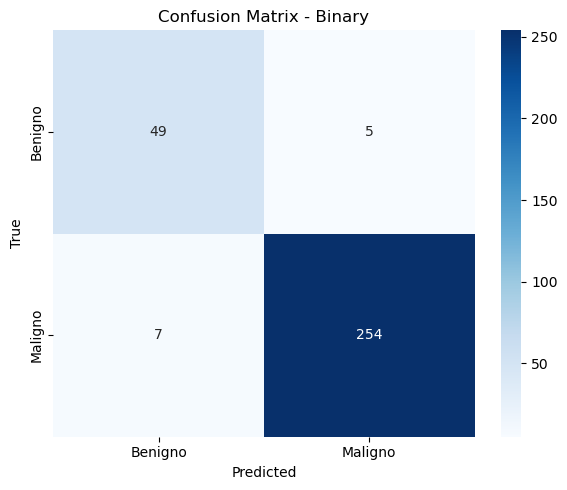

In [197]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
import torch.nn as nn
import torch.optim as optim
import random

# Riproducibilità
random.seed(42)
torch.manual_seed(42)

# === CONFIGURAZIONE ===
base_dir = os.getcwd()
n_components = 146
batch_size = 32
epochs = 100
output_folder = os.path.join(base_dir, "pca_outputs")
save_path = os.path.join(output_folder, f'pca_data_{n_components}_augmented.pth')
log_txt_path = os.path.join(output_folder, "classification_reports_binary.txt")
pretty_labels_binary = ['Benigno', 'Maligno']

data_dict = torch.load(save_path, weights_only=False)
X_train = torch.tensor(data_dict['train_data'], dtype=torch.float32)
y_train = torch.tensor(data_dict['train_labels'], dtype=torch.long)
X_val = torch.tensor(data_dict['val_data'], dtype=torch.float32)
y_val = torch.tensor(data_dict['val_labels'], dtype=torch.long)
X_test = torch.tensor(data_dict['test_data'], dtype=torch.float32)
y_test = torch.tensor(data_dict['test_labels'], dtype=torch.long)

# === BINARIZZAZIONE ETICHETTE ===
# 'Normal' = classe benigno, indice 2
def binarize(y):
    return (y != 2).long()  # 0 = benigno, 1 = maligno

y_train = binarize(y_train)
y_val = binarize(y_val)
y_test = binarize(y_test)

# === SCALING + PCA ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# === TENSORI + DATALOADER ===
X_train_t = torch.tensor(X_train_pca, dtype=torch.float32)
X_val_t = torch.tensor(X_val_pca, dtype=torch.float32)
X_test_t = torch.tensor(X_test_pca, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_train_t, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_t, y_test), batch_size=batch_size)

# === MODELLO BINARIO ===
class BinaryNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        return torch.sigmoid(self.fc2(x)).squeeze(1)  # output [batch]

# === INIZIALIZZAZIONE ===
model = BinaryNet(input_dim=n_components, hidden_dim=64, dropout=0.5)
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.BCELoss() # pesa in base alla label batch
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# === TRAINING ===
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=10, patience=10):
    best_val_loss = float('inf')
    trigger_times = 0
    best_model_state = model.state_dict()

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = (output > 0.5).long()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
        train_acc = 100 * correct / total

        # VALIDAZIONE
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output, y_batch.float())
                val_loss += loss.item()
                preds = (output > 0.5).long()
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.size(0)
        val_acc = 100 * val_correct / val_total

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            best_model_state = model.state_dict()
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("🛑 Early stopping triggered.")
                break

        if scheduler:
            scheduler.step(val_loss)

    model.load_state_dict(best_model_state)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=scheduler, epochs=epochs, patience=10)

# === TEST FINALE ===
model.eval()
y_true, y_pred, test_loss = [], [], 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        loss = criterion(output, y_batch.float())
        preds = (output > 0.5).long()
        test_loss += loss.item()
        y_true.extend(y_batch.tolist())
        y_pred.extend(preds.tolist())

test_acc = accuracy_score(y_true, y_pred)
print(f"\n📊 Final Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}")
print(classification_report(y_true, y_pred, target_names=pretty_labels_binary))

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=pretty_labels_binary, yticklabels=pretty_labels_binary, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Binary")
plt.tight_layout()
plt.show()
